In [4]:
import torch
from torch.utils.data import DataLoader, random_split # loads data either in chunks or full
import torch.nn.functional as F
from torchvision import datasets # open datasets
from torchvision.transforms import ToTensor # transfor data to tensor
import matplotlib.pyplot as plt
import random

In [11]:
train_data = datasets.MNIST(root='./data/', train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root='./data/', train=False, download=True, transform=ToTensor())


In [13]:
batch_size = 64

train_size = int(len(train_data) * 0.8)  # 80% of the data for training
val_size = len(train_data) - train_size  # 20% of the data for validation
train_subset, val_subset = random_split(train_data, [train_size, val_size])

train_dataloader = DataLoader(train_subset, batch_size=batch_size) 
val_dataloader = DataLoader(val_subset, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Name: 4, Number: 4


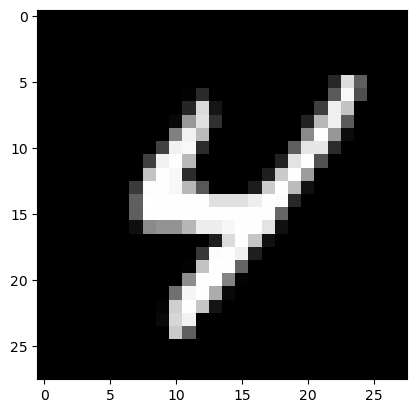

In [37]:
images, labels = next(iter(train_dataloader))
idx = torch.randint(0, 64, (1,)).item()
image = images[idx].squeeze()
label = labels[idx]
print(f"Name: {label.item()}, Number: {label.item()}")
plt.imshow(image, cmap="grey")
plt.show()

In [40]:
class Optimizer:
    def __init__(self, parameters, lr, name):
        self.parameters = parameters
        self.lr = lr
        self.name = name

        self.momentum = 0.9
        self.velocities = [torch.zeros_like(p) for p in parameters]

        self.decay_rate = 0.999
        self.epsilon = 1e-8
        self.sq_grads = [torch.zeros_like(p) for p in parameters]

        self.beta1 = 0.9
        self.beta2 = 0.999
        self.m_t = [torch.zeros_like(p) for p in parameters]
        self.v_t = [torch.zeros_like(p) for p in parameters]
        self.t = 0

    def step(self):
        if self.name == "stochastic":
            self.stochastic_step()
        elif self.name == "momentum":
            self.momentum_step()
        elif self.name == "RMSprop":
            self.RMSprop_step()
        elif self.name == "Adam":
            self.Adam_step()
        else:
            print("no valid optimizer with such name")

    def stochastic_step(self):
        with torch.no_grad():
            for param in self.parameters:
                if param is not None:
                    param -= param.grad * self.lr
                    # param.grad.zero_()

    def momentum_step(self):
        with torch.no_grad():
            for param, velocity in zip(self.parameters, self.velocities):
                if param is not None:
                    # view momentum as the mass that scales the last velocity a bit but still gives more direction
                    # the rest is just the stochatic gradient descent
                    velocity.mul_(self.momentum).add_(param.grad, alpha=self.lr)
                    param.sub_(velocity)
                    # param.grad.zero_()

                    # another way
                    # higher the momentum closer it pays attention to the upcoming points
                    # lower the momentum closer it pays attention to the previous points
                    # velocity.mul_(self.momentum).add_(param.grad, alpha=(1 - self.momentum))
                    # param.sub_(velocity, alpha=self.lr)
                    # param.grad.zero_()
    
    def RMSprop_step(self):
        with torch.no_grad():
            for param, sq_grad in zip(self.parameters, self.sq_grads):
                if param.grad is not None:
                    sq_grad.mul_(self.decay_rate).addcmul_(param.grad, param.grad, value=1 - self.decay_rate)
                    sqrt = sq_grad.sqrt().add(self.epsilon)
                    adjusted_grad = param.grad / sqrt
                    param.sub_(adjusted_grad, alpha=self.lr)

    def Adam_step(self):
        with torch.no_grad():
            self.t += 1
            for param, m, v in zip(self.parameters, self.m_t, self.v_t):
                if param is not None:
                    m.mul_(self.beta1).add_(param.grad, alpha=1 - self.beta1)
                    v.mul_(self.beta2).addcmul_(param.grad, param.grad, value=1 - self.beta2)
                    m_hat = m / (1 - self.beta1 ** self.t)
                    v_hat = v / (1 - self.beta2 ** self.t)
                    param.sub_(m_hat / (v_hat.sqrt().add(self.epsilon)), alpha=self.lr)

    def zero_grads(self):
        with torch.no_grad():
            for param in self.parameters:
                if param.grad is not None:
                    param.grad.zero_()

In [38]:
class Conv2d:
    def __init__(self, out_channels, in_channels, kernel_size, stride=1, padding=0, processor="cuda:0"):
        self.w = torch.randn((out_channels, in_channels, kernel_size[0], kernel_size[1]), device=processor, requires_grad=True)
        self.b = torch.randn(out_channels, device=processor, requires_grad=True)
        self.stride = stride
        self.padding = padding
        self.processor = processor
    
    def __call__(self, input):
        batch_size, in_channels, in_height, in_width = input.shape
        out_channels, _, kernel_height, kernel_width = self.w.shape

        out_height = (in_height - kernel_height + 2 * self.padding) // self.stride + 1
        out_width = (in_width - kernel_width + 2 * self.padding) // self.stride + 1

        unfolded_input = torch.zeros(batch_size, out_height, out_width, in_channels * kernel_height * kernel_width, device=self.processor) # [64, 27, 27, 4]

        for i in range(out_height):
            for j in range(out_width):
                start_i = i * self.stride
                end_i = start_i + kernel_height
                start_j = j * self.stride
                end_j = start_j + kernel_width

                patch = input[:, :, start_i:end_i, start_j:end_j]
                patch = patch.reshape(batch_size, -1)
                
                unfolded_input[:, i, j, :] = patch
        
        unfolded_input = unfolded_input.view(batch_size * out_height * out_width, in_channels * kernel_height * kernel_width)
        unfolded_kernel = self.w.view(out_channels, -1).t()
        
        unfolded_output = torch.matmul(unfolded_input, unfolded_kernel)  # [64 * 27 * 27, 12]
        output = unfolded_output.view(batch_size, out_height, out_width, out_channels)  # [64, 27, 27, 12]
        output = output.permute(0, 3, 1, 2).contiguous()

        output += self.b.view(1, out_channels, 1, 1)

        return output
    
    def parameters(self):
        return [self.w, self.b]

In [39]:
class MaxPool2d:
    def __init__(self, w_size, processor="cuda:0"):
        self.w_size = w_size
        self.processor = processor

    def __call__(self, input):
        batch_size, in_channels, in_height, in_width = input.shape
        kernel_height, kernel_width = self.w_size

        out_height = in_height // kernel_height
        out_width = in_width // kernel_width

        output = torch.zeros(batch_size, in_channels, out_height, out_width, device=self.processor) # [64, 27, 27, 4]

        for i in range(out_height):
            for j in range(out_width):
                start_i = i * kernel_height
                end_i = start_i + kernel_height
                start_j = j * kernel_width
                end_j = start_j + kernel_width

                window = input[:, :, start_i:end_i, start_j:end_j]
                max_values_height, _ = window.max(dim=2, keepdim=True)  # Compute max along height dimension
                max_values, _ = max_values_height.max(dim=3, keepdim=True)  # Compute max along width dimension
                output[:, :, i, j] = max_values.squeeze() # do not first dim as 1
                
        return output
    
    def parameters(self):
        return []

In [41]:
class Layer: 
    # nin is the number of input (prev layer)
    # nout is the number of output (next layer)
    def __init__(self, nin, nout, processor):
        self.w = torch.randn((nin, nout), requires_grad=True, device=processor)
        self.b = torch.randn(1, requires_grad=True, device=processor)
    
    # x is the input in (batch, input)
    def __call__(self, x):
        eq = torch.matmul(x, self.w) + self.b
        out = torch.tanh(eq)
        return out # returns (batch, output # of neurons for next layer)
    
    def parameters(self):
        return [self.w, self.b]
    
class MLP:
    def __init__(self, nin, nouts, processor="cuda:0"):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1], processor) for i in range(len(nouts))]

    def __call__(self, x):
        x = x.view(x.size(0), -1)

        for layer in self.layers:
            x = layer(x)
        return torch.softmax(x, dim=1)
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    


In [42]:
class CNN():
    def __init__(self, *layers, lr, optimizer="stochastic"):
        self.layers = layers
        self.optimizer = Optimizer(self.parameters(), lr, optimizer)

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def update_parameters(self):
        self.optimizer.step()

    def zero_grads(self):
        self.optimizer.zero_grads()


In [47]:
def train(cnn, loss_fn):
    for batch, (x, y) in enumerate(train_dataloader):
        x, y = x.to("cuda:0"), y.to("cuda:0")
        
        output = cnn(x)

        loss = loss_fn(output, y)

        cnn.zero_grads()
        
        loss.backward()

        cnn.update_parameters()

        if batch % 100 == 0:
            print(f"Loss: {loss:>7f}\t [{((batch + 1) * 64):>5d}/{937 * 64}]")

In [44]:
def validate(cnn, loss_fn):
    tot = 0
    correct = 0

    with torch.no_grad():
        for x, y in val_dataloader:
            x, y = x.to("cuda:0"), y.to("cuda:0")

            output = cnn(x)

            loss = loss_fn(output, y)
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
            tot += y.size(0)

    accuracy = correct / tot * 100
    return loss, accuracy

In [45]:
def test(cnn):
    tot = 0
    correct = 0

    with torch.no_grad():
        for test_x, test_y in test_dataloader:
            test_x, test_y = test_x.to("cuda:0"), test_y.to("cuda:0")

            output = cnn(test_x)
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(test_y.view_as(pred)).sum().item()
            tot += test_y.size(0)

    accuracy = correct / tot * 100
    print(f"Test Accuracy: {accuracy:.2f}%\n")

In [62]:
cnn = CNN(Conv2d(4, 1, (1, 1)), 
          MaxPool2d((2, 2)), 
          MLP(784, [64, 32, 10]), lr=0.004, optimizer="Adam")
loss_fn = torch.nn.CrossEntropyLoss()

In [60]:
for i in range(25):
    print(f"Epoch {i + 1}")
    print("-----------------------------------------")
    train(cnn, loss_fn)
    loss, accuracy = validate(cnn, loss_fn)
    print(f"Loss: {loss:>7f} Accuracy: {accuracy:>5f}\n")


Epoch 1
-----------------------------------------
Loss: 2.303927	 [   64/59968]
Loss: 2.247971	 [ 6464/59968]
Loss: 2.202401	 [12864/59968]
Loss: 2.203810	 [19264/59968]
Loss: 2.198919	 [25664/59968]
Loss: 2.136386	 [32064/59968]
Loss: 2.097185	 [38464/59968]
Loss: 2.128354	 [44864/59968]
Loss: 2.122977 Accuracy: 64.816667

Epoch 2
-----------------------------------------
Loss: 2.076894	 [   64/59968]
Loss: 2.072985	 [ 6464/59968]
Loss: 2.081472	 [12864/59968]
Loss: 2.090505	 [19264/59968]
Loss: 2.098557	 [25664/59968]
Loss: 2.098795	 [32064/59968]
Loss: 2.033694	 [38464/59968]
Loss: 2.067120	 [44864/59968]
Loss: 2.091766 Accuracy: 73.783333

Epoch 3
-----------------------------------------
Loss: 2.056135	 [   64/59968]
Loss: 2.056592	 [ 6464/59968]
Loss: 2.063082	 [12864/59968]
Loss: 2.051788	 [19264/59968]
Loss: 2.063281	 [25664/59968]
Loss: 2.049937	 [32064/59968]
Loss: 2.025012	 [38464/59968]
Loss: 2.042135	 [44864/59968]
Loss: 2.072970 Accuracy: 79.875000

Epoch 4
--------------

In [61]:
test(cnn)

Test Accuracy: 93.18%

